**OBJECTIVE:** Illustrate how to run the foundational model with `VimureModel` class

**LAST UPDATED:** 27/12/2021

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import vimure as vm
import networkx as nx
import matplotlib.pyplot as plt

from plotnine import * 

# Generate network

## Generate Y

(see Notebook 01 for more information about the synthetic network models used in the study)

Let us generate a synthetic network with reciprocity (`Multitensor`):

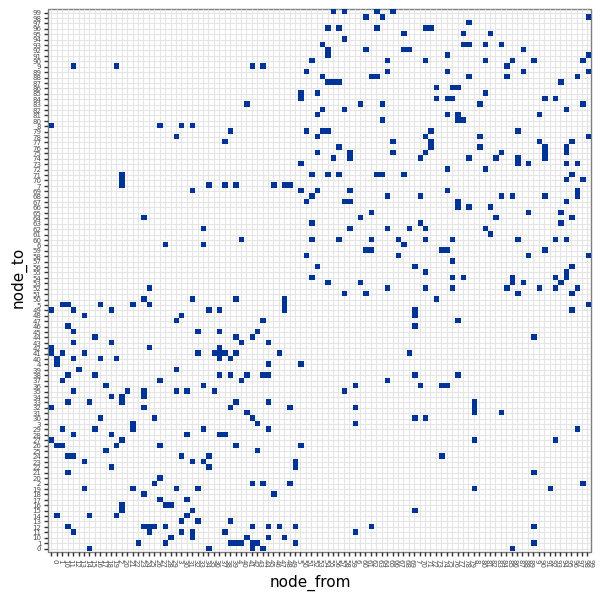

<ggplot: (8789797559366)>

In [2]:
random_net = vm.synthetic.Multitensor(N=100, 
                                        M=100, 
                                        L=1, 
                                        C=2, 
                                        K=2, 
                                        avg_degree=10,
                                        sparsify=True,
                                        seed=25,
                                        eta=0.2) # Eta is the expected reciprocity on the network

layer = 0

Y = random_net.Y.toarray()

g, node_order = vm.extras.plot.plot_adjacency_matrix(A=Y[layer,:,:],
                                              return_node_order=True,
                                              
                                              #Optional visualisation parameters
                                              gradient_low="#86cefa",
                                              gradient_mid="#003396",
                                              hide_legend=True)
g

What is the actual overall reciprocity of the network?

In [3]:
vm.utils.calculate_overall_reciprocity(Y[0])

0.23736263736263735

**Highly reciprocated ties**

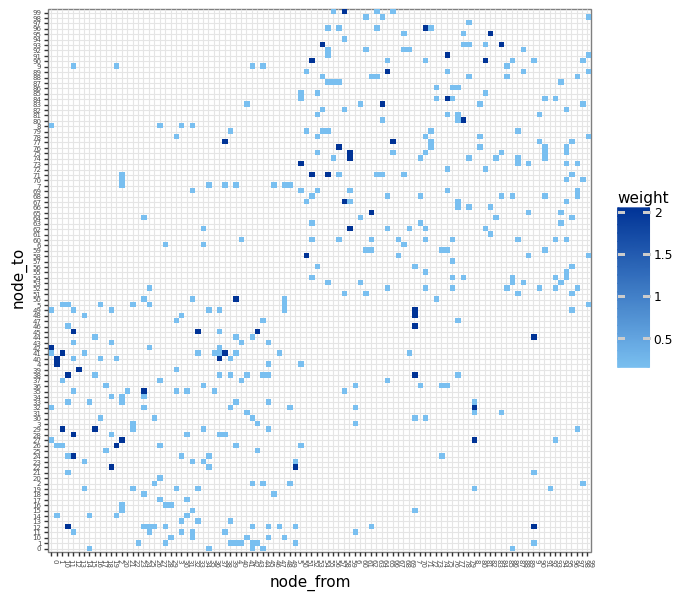

<ggplot: (8789797681125)>

In [4]:
rec_mask = np.logical_and(np.triu(Y[0]) > 0, np.tril(Y[0]).T > 0 ).astype('float')
rec_mask_true = rec_mask == True
rec_mask[Y[0]>0] = 0.2
rec_mask[rec_mask_true] = 2
vm.extras.plot.plot_adjacency_matrix(rec_mask, node_order=node_order)

## Generate X

(see Notebook 01 for more information about the synthetic network models used in the study)

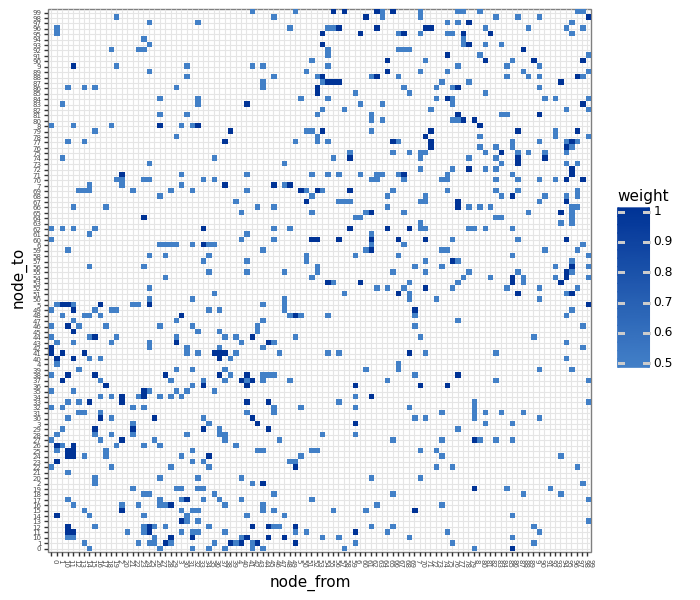

<ggplot: (8789794772755)>

In [5]:
random_net.build_X(cutoff_X=True, mutuality=0.3, lambda_diff=1.0, flag_self_reporter=True)

Xavg = vm.utils.calculate_average_over_reporter_mask(random_net.X, random_net.R)

g = vm.extras.plot.plot_adjacency_matrix(Xavg[0], node_order=node_order)
g

## Distribution of $\theta$

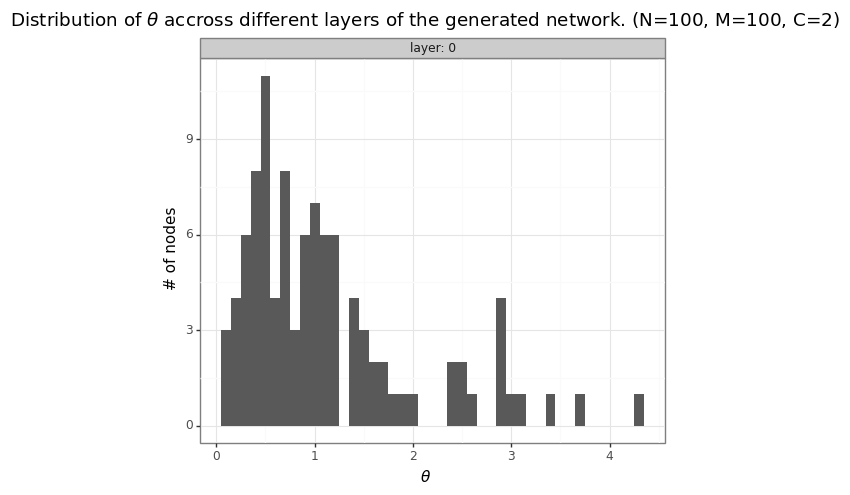

<ggplot: (8789797564062)>

In [6]:
theta_df = pd.concat([pd.DataFrame({'layer': l, 'theta': random_net.theta[l]}) for l in range(random_net.L)])  
theta_df["layer"] = theta_df["layer"].astype(str)

g = (ggplot(theta_df, aes(x="theta")) + 
     geom_histogram(binwidth=0.1) + 
     xlab(r"$\theta$") +
     ylab("# of nodes") +
     theme_bw() +
     theme(
         # Figure Size
        figure_size=(6, 5),
        ) +
    facet_grid("~ layer", labeller="label_both") + 
    ggtitle(r"Distribution of $\theta$ accross different layers of the generated network. (N=%d, M=%d, C=%d)" % 
            (random_net.N, random_net.M, random_net.C))) 

g

# Baseline

## Union of X

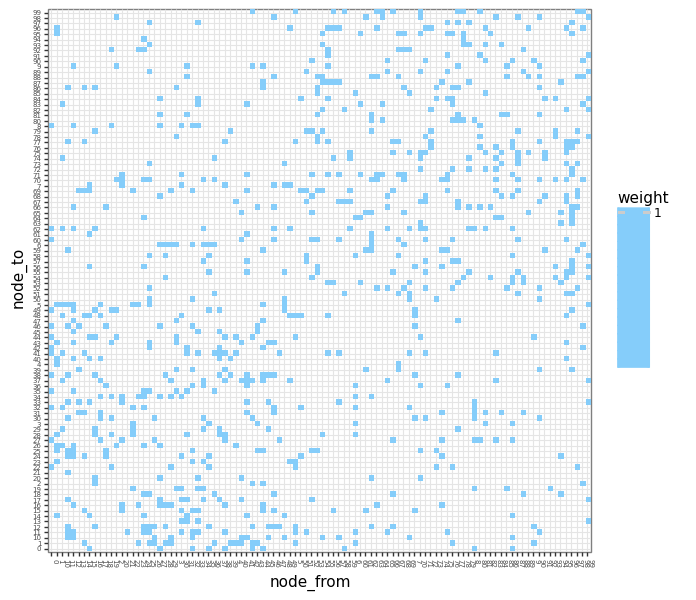

<ggplot: (8789794925157)>

In [7]:
X_union = random_net.X_union.toarray()[0]

g = vm.extras.plot.plot_adjacency_matrix(X_union, node_order=node_order)
g

## Intersection of X

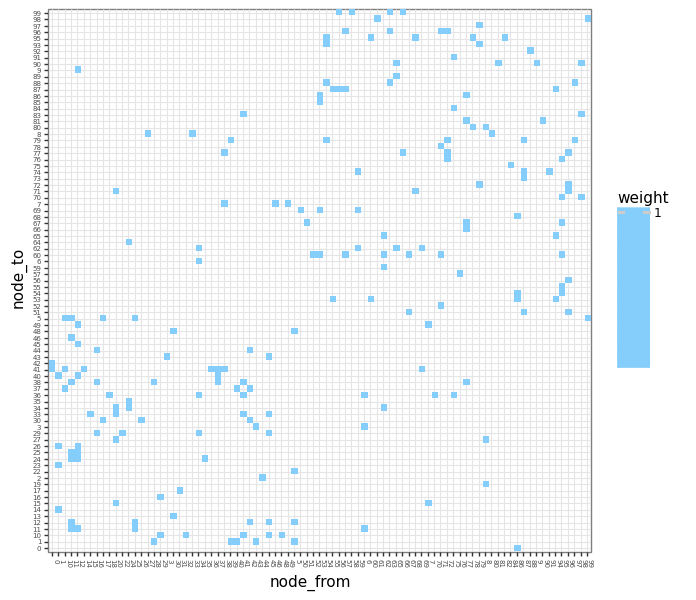

<ggplot: (8789793380788)>

In [8]:
X_intersection = random_net.X_intersection.toarray()[0]

g = vm.extras.plot.plot_adjacency_matrix(X_intersection, node_order=node_order)
g

# VIMuRe model

[VimureModel](https://github.com/latentnetworks/vimure/blob/main/src/python/vimure/model.py#L26) class follows the same standard as [scikit-learn estimators](https://scikit-learn.org/stable/developers/develop.html).

Its constructor contains the following parameters:

- **undirected**: bool = False -- whether the network is undirected
- **mutuality**: bool = True -- whether to use the mutuality parameter
- **convergence_tol**: float = 0.1 -- controls when to stop the optimisation algorithm (CAVI)
- **verbose**: bool = True


## Parameters to `fit` method

When fitting the model to data, one can inform priors to the algorithm and change the setup of the optimisation algorithm if desired. These are the allowed parameters for the `VimureModel.fit(...)` method:


**Data**

- **X**: sktensor or np.ndarray -- The observed data, with dimensions L x N x N x N
- **R**: sktensor or np.ndarray -- Reporters mask (TRUE/FALSE) indicating whether a node _CAN_ report on a particular tie, with dimenstions L x N x N x N

(see [scikit-tensor-py3](https://github.com/evertrol/scikit-tensor-py3) to learn more about the tensor representation used here) 

**Priors**

- **theta_prior**=(0.1, 0.1) -- $\theta$ is modelled as a gamma distribution, these parameters control the shape and scale of that distribution
- **lambda_prior**=(10.0, 10.0) --  $\lambda$ is modelled as a gamma distribution, these parameters control the shape and scale of that distribution
- **eta_prior**=(0.5, 1.0) -- $\eta$ is modelled as a gamma distribution, these parameters control the shape and scale of that distribution
- **rho_prior**=None -- if None, ties which have not been reported by any node will have $\rho_{ij,k=0}=1$ and $\rho_{ij,k}=0 ~\vert~ \forall k \ne 0$ and the remaining ties will be drawn from a random normal distribution. 
- **seed**: int = None

**Other parameters**
- **K** -- default: X.max() + 1
- **max_iter** -- default: 20 | Maximum number of iterations to update ELBO values, regardless if it reached full convergence
- **num_realisations** -- default: 20 | Number of times to run the model -- New seeds are generated automatically

## Run model without mutuality ($\eta = 0$)

This is not particularly useful since we know this network has some level of reciprocity and mutuality.

In [9]:
model = vm.model.VimureModel(mutuality=False) 
model.fit(X=random_net.X, R=random_net.R, K=2, num_realisations=1, max_iter=150) 

2023-02-23 14:14:33,704 - [PID 2556] - vm.model.VimureModel      - DEBUG - Checking user parameters passed to the VimureModel.fit()
2023-02-23 14:14:33,705 - [PID 2556] - vm.model.VimureModel      - DEBUG - Initializing priors
2023-02-23 14:14:33,715 - [PID 2556] - vm.model.VimureModel      - DEBUG - Setting priors on rho
2023-02-23 14:14:33,790 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter    1 | ELBO value: -501395.364898988511 | Reached convergence: False
2023-02-23 14:14:34,081 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   10 | ELBO value: -501157.856990805187 | Reached convergence: False
2023-02-23 14:14:34,380 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   20 | ELBO value: -501137.261177402164 | Reached convergence: False
2023-02-23 14:14:34,691 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   30 | ELBO value: -501129.110786818375 | Reached convergence: False
2023-02-23 1

VimureModel(mutuality=False)

The Diagnostics class helps to identify the key results made by the algorithm:

In [10]:
diag_obj = vm.diagnostics.Diagnostics(model, random_net)
diag_obj

---------------
- DIAGNOSTICS -
---------------

Model: ViMuRe(F)

  Priors:
   - eta:    shp=0.50 rte=1.00
   - theta:  shp=0.10 rte=0.10
   - lambda: shp=10.0 rte=10.0
   - rho:    a (1, 100, 100, 2) tensor (to inspect it, run <diag_obj>.model.pr_rho)

  Posteriors:
   - G_exp_lambda_f: [[0.0018612  1.57572226]]
   - G_exp_nu_f: 0.00
   - G_exp_theta_f: a (1, 100) tensor (to inspect it, run <diag_obj>.model.G_exp_theta_f)
   - rho_f: a (1, 100, 100, 2) tensor (to inspect it, run <diag_obj>.model.rho_f)

Optimisation:

   Elbo: -501119.094297868782

The variable $\nu$ is the latent variable that represents the mutuality inferred by the algorithm. Since we ran the model with `mutuality=False`, G_exp_nu = 0 as expected.

**What about the reliability variable, has the model been able to retrieve the same order of the ground-truth planted reliability?**

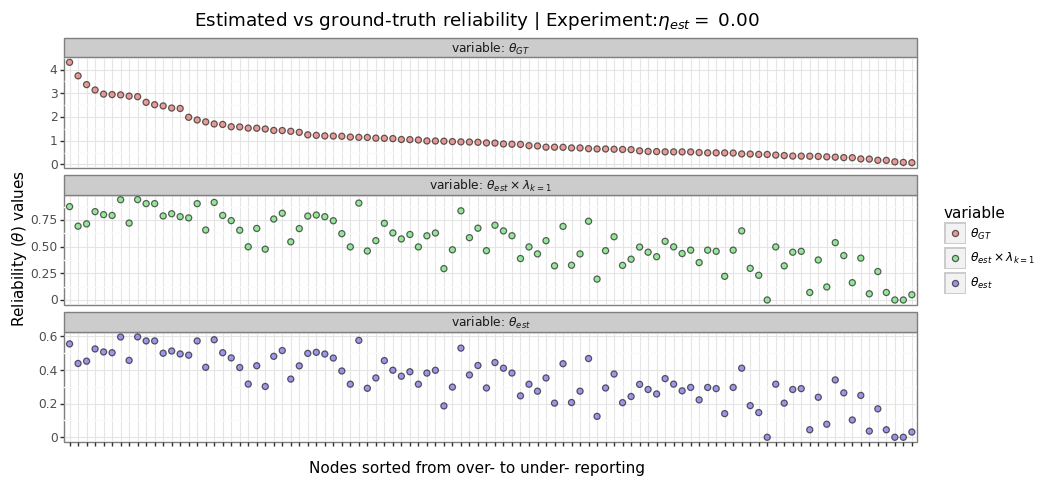

<ggplot: (8789793201738)>

In [11]:
g = diag_obj.plot_theta(theta_GT=random_net.theta, return_node_order=False)

g

Indeed, $\theta_{GT}$ and estimated $\theta$ are highly correlated:

In [12]:
sp.stats.spearmanr(random_net.theta[0], model.G_exp_theta_f[0])

SignificanceResult(statistic=0.8309270927092708, pvalue=1.0721077824649573e-26)

**However, once we try to replicate the ground-truth network (from $\rho_f$), the adjacency matrix obtained is very similar to the union baseline:**

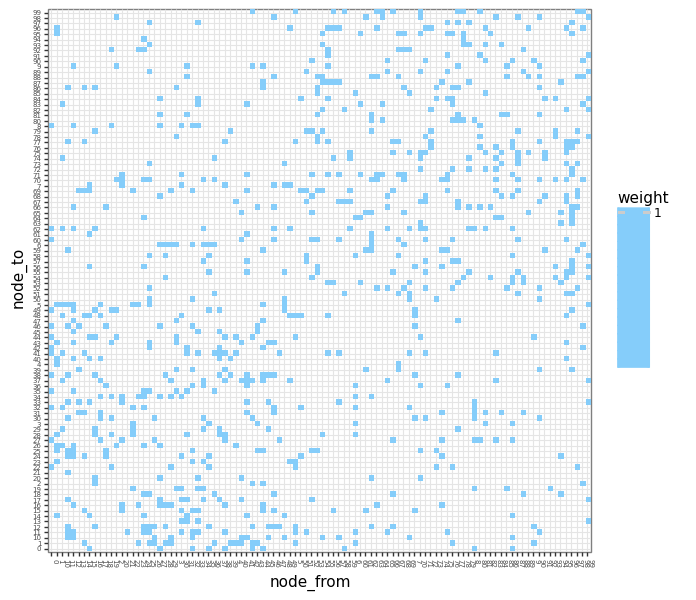

<ggplot: (8789795075556)>

In [13]:
rho_sub_max = np.argmax(model.rho_f, axis=-1)[0]
vm.extras.plot.plot_adjacency_matrix(rho_sub_max, node_order=node_order)

Overall reciprocity on ground truth network:

In [14]:
print(f"Reciprocity in the original network: \t\t\t{vm.utils.calculate_overall_reciprocity(random_net.Y.toarray()[0]):.3f}")
print(f"Reciprocity in the recovered network (mutuality=False)\t{vm.utils.calculate_overall_reciprocity(rho_sub_max):.3f}")

Reciprocity in the original network: 			0.237
Reciprocity in the recovered network (mutuality=False)	0.556


## Run model for network generated with mutuality

In [15]:
model = vm.model.VimureModel(mutuality=True) 
model.fit(X=random_net.X, R=random_net.R, K=2, num_realisations=1, max_iter=150, seed=0)

2023-02-23 14:14:41,422 - [PID 2556] - vm.model.VimureModel      - DEBUG - Checking user parameters passed to the VimureModel.fit()
2023-02-23 14:14:41,460 - [PID 2556] - vm.model.VimureModel      - DEBUG - Initializing priors
2023-02-23 14:14:41,461 - [PID 2556] - vm.model.VimureModel      - DEBUG - Setting priors on rho
2023-02-23 14:14:41,545 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter    1 | ELBO value: -1474.766772312868 | Reached convergence: False
2023-02-23 14:14:41,815 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   10 | ELBO value: -921.729425180590 | Reached convergence: False
2023-02-23 14:14:42,081 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   20 | ELBO value: -893.846406622860 | Reached convergence: False
2023-02-23 14:14:42,345 - [PID 2556] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   30 | ELBO value: -885.506864425063 | Reached convergence: False
2023-02-23 14:14:42,656

VimureModel()

In [16]:
diag_obj = vm.diagnostics.Diagnostics(model, random_net)
diag_obj

---------------
- DIAGNOSTICS -
---------------

Model: ViMuRe(T)

  Priors:
   - eta:    shp=0.50 rte=1.00
   - theta:  shp=0.10 rte=0.10
   - lambda: shp=10.0 rte=10.0
   - rho:    a (1, 100, 100, 2) tensor (to inspect it, run <diag_obj>.model.pr_rho)

  Posteriors:
   - G_exp_lambda_f: [[0.0017548  1.47129794]]
   - G_exp_nu_f: 0.39
   - G_exp_theta_f: a (1, 100) tensor (to inspect it, run <diag_obj>.model.G_exp_theta_f)
   - rho_f: a (1, 100, 100, 2) tensor (to inspect it, run <diag_obj>.model.rho_f)

Optimisation:

   Elbo: -877.910801437565

Note that, this time, the algorithm has estimated some nonzero value for `G_exp_nu_f`.

And the inferred theta is still highly correlated with ground truth values:

In [17]:
sp.stats.spearmanr(random_net.theta[0], model.G_exp_theta_f[0])

SignificanceResult(statistic=0.7242844284428441, pvalue=1.6515721804493586e-17)

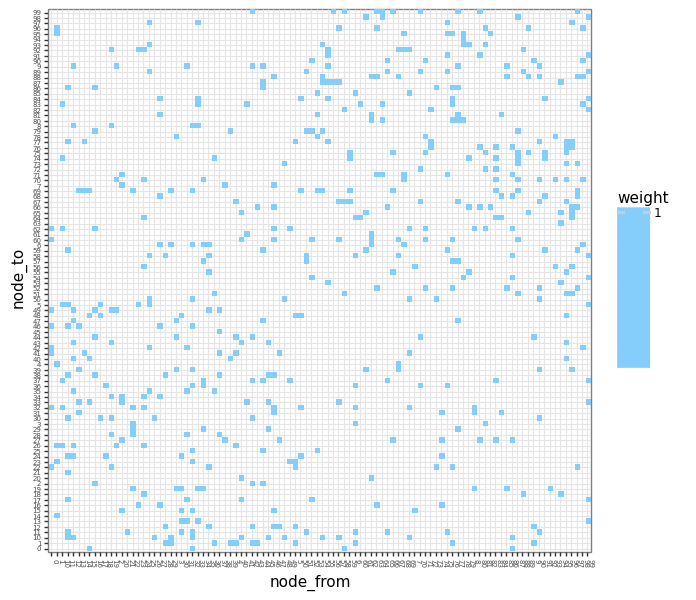

<ggplot: (8789788418244)>

In [18]:
rho_f = model.rho_f[0,:,:,1]
fixed_threshold = 0.23

rho_f[rho_f < fixed_threshold] = 0
rho_f[rho_f >= fixed_threshold] = 1


vm.extras.plot.plot_adjacency_matrix(rho_f, node_order=node_order)

The reciprocity values now match more closely to the ones of the ground truth:

In [19]:
print(f"Reciprocity in the original network: \t\t\t{vm.utils.calculate_overall_reciprocity(random_net.Y.toarray()[0]):.3f}")
print(f"Reciprocity in the recovered network (mutuality=False)\t{vm.utils.calculate_overall_reciprocity(rho_f):.3f}")

Reciprocity in the original network: 			0.237
Reciprocity in the recovered network (mutuality=False)	0.170
